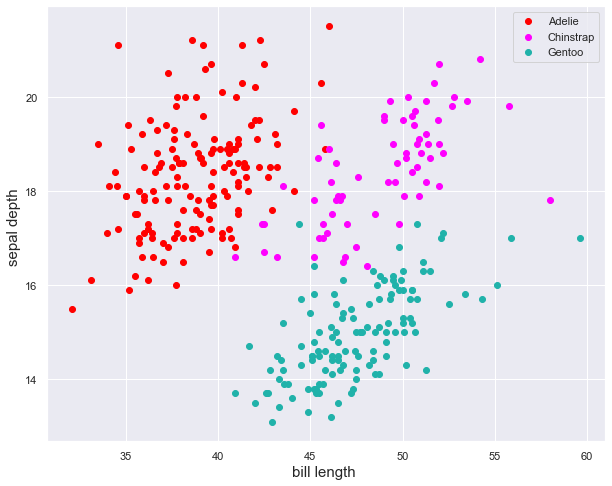

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set theme for plotting
sns.set_theme()

# Import the data
df=pd.read_csv("Datasets/palmer_penguins.csv")

# Plot the data
penguins = ["Adelie", "Chinstrap", "Gentoo"]
colors = ["red", "magenta", "lightseagreen"]

fig, ax = plt.subplots(figsize = (10, 8))
for species, color in zip(penguins, colors):
    temp_df = df[df.species == species]
    ax.scatter(temp_df.bill_length_mm,
               temp_df.bill_depth_mm,
               c = color,
               label = species, 
               )
    
ax.set_xlabel("bill length ", fontsize = 15)
ax.set_ylabel("sepal depth ", fontsize = 15)
ax.legend()
plt.show()

---

Notice in the image above that most of the time, similar data points are close to each other. The KNN algorithm hinges on this assumption being true enough for the algorithm to be useful. KNN captures the idea of similarity (sometimes called distance, proximity, or closeness) with some mathematics we might have learned in our childhood— calculating the distance between points on a graph.

### The KNN Algorithm
1. Load the data
2. Initialize K to your chosen number of neighbors
3. For each example in the data
 - 3.1 Calculate the distance between the query example and the current example from the data.
 - 3.2 Add the distance and the index of the example to an ordered collection
4. Sort the ordered collection of distances and indices from smallest to largest (in ascending order) by the distances
5. Pick the first K entries from the sorted collection
6. Get the labels of the selected K entries
7. If regression, return the mean of the K labels
8. If classification, return the mode of the K labels


Before implementing this algorithm we creat a training set and testing set by running the following code.

---

In [5]:
from sklearn.model_selection import train_test_split

X = df[["bill_length_mm",
          "bill_depth_mm"]].to_numpy()

y = df["species"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

---

For our distance measure, we will choose the **Euclidean distance** defined by the following equation:

$$
d(p, q) = \sqrt{(p - q)^{T} (p - q)}
$$


---

In [6]:
def distance(p, q):
    return np.sqrt((p - q) @ (p - q))

print(f"The distance between point 10 and 67 is {distance(X[10], X[67])}")

The distance between point 10 and 67 is 3.8587562763149514


---

With our distance function, we are now ready to write a function to compute the $k$-nearest neighbors to a given point. This is done in the code cell below. 

---

In [7]:
def k_nearest_neighbors(point, 
                        training_features, 
                        training_labels, 
                        k):
    # Create an empty list to store neighbors and distances
    neighbors = []
    
    for p, label in zip(training_features, training_labels):
        d = distance(point, p)
        temp_data = [p, label, d]
        neighbors.append(temp_data)
        
    neighbors.sort(key = lambda x : x[-1])
    
    return neighbors[:k]

In [8]:
k_nearest_neighbors(X_test[-1], X_train, y_train, 5)

[[array([50.8, 19. ]), 'Chinstrap', 0.5],
 [array([52., 19.]), 'Chinstrap', 1.3000000000000027],
 [array([50.3, 20. ]), 'Chinstrap', 1.5811388300841898],
 [array([51.7, 20.3]), 'Chinstrap', 2.012461179749814],
 [array([50. , 16.3]), 'Gentoo', 2.3409399821439236]]

In [9]:
y_test[-1]

'Chinstrap'

---

Now that we have a function to compute the $k$-nearest neighbors to a point, we can now write a function to predict a target label. However, we should note that KNN can be used for both classification and regression machine learning. This is shown in the code cell below. 

---

In [10]:
def KNN_Predict(point, 
                training_features, 
                training_labels, 
                k, 
                regression = False):
    
    neighbors = k_nearest_neighbors(point, 
                                    training_features, 
                                    training_labels, 
                                    k)
    
    if regression == False:
        labels = [x[1] for x in neighbors]
        return max(labels, key = labels.count)
    
    else:
        return sum(x[1] for x in neighbors)/k

In [11]:
KNN_Predict(X_test[-1], X_train, y_train, 5)

'Chinstrap'

In [12]:
def classification_error(test_features, 
                         test_labels,
                         training_features, 
                         training_labels,
                         k):
    error = 0
    for point, label in zip(test_features, test_labels):
        error += label != KNN_Predict(point, 
                                      training_features, 
                                      training_labels, 
                                      k)
    return error/len(test_features)

In [13]:
classification_error(X_test, y_test, X_train, y_train, 7)

0.06140350877192982

## Choosing the right value for K
To select the K that’s right for your data, we run the KNN algorithm several times with different values of K and choose the K that reduces the number of errors we encounter while maintaining the algorithm’s ability to accurately make predictions when it’s given data it hasn’t seen before.

Here are some things to keep in mind:

1. As we decrease the value of K to 1, our predictions become less stable. Just think for a minute, imagine K=1 and we have a query point surrounded by several reds and one green (I’m thinking about the top left corner of the colored plot above), but the green is the single nearest neighbor. Reasonably, we would think the query point is most likely red, but because K=1, KNN incorrectly predicts that the query point is green.
2. Inversely, as we increase the value of K, our predictions become more stable due to majority voting / averaging, and thus, more likely to make more accurate predictions (up to a certain point). Eventually, we begin to witness an increasing number of errors. It is at this point we know we have pushed the value of K too far.
3. In cases where we are taking a majority vote (e.g. picking the mode in a classification problem) among labels, we usually make K an odd number to have a tiebreaker.

### Then how to select the optimal K value?
* There are no pre-defined statistical methods to find the most favorable value of K.
* Initialize a random K value and start computing.
* Choosing a small value of K leads to unstable decision boundaries.
* The substantial K value is better for classification as it leads to smoothening the decision boundaries.
* Derive a plot between error rate and K denoting values in a defined range. Choose the K value having the minimum error rate. 

### Advantages
* The algorithm is simple and easy to implement.
* There’s no need to build a model, tune several parameters, or make additional assumptions.
* The algorithm is versatile. It can be used for classification, regression, and search (as we will see in the next section).


### Disadvantages
* The algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.

In [14]:
possible_k = [k for k in range(3, 26, 2)]
errors = [classification_error(X_test,
                               y_test,
                               X_train,
                               y_train, k) for k in possible_k]

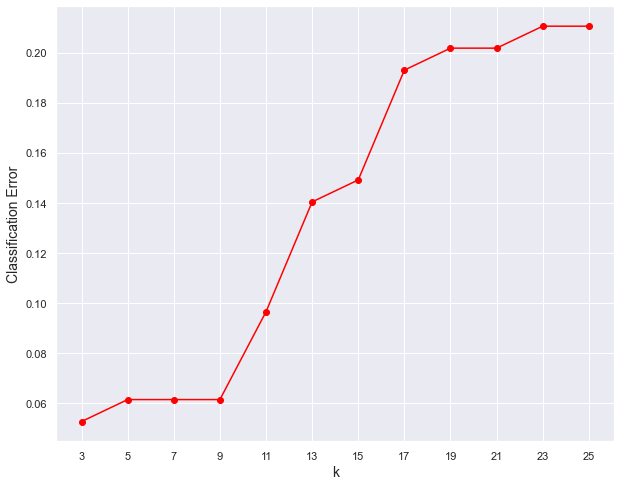

In [15]:
plt.figure(figsize = (10, 8))
plt.plot(possible_k, errors, color = 'red', marker = "o")
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.xticks(possible_k)
plt.show()